## CNN-(Convolutional Neural Network)

### 卷积神经网络

卷积神经网络(CNN)是现代神经网络的经典代表，被广泛应用在了图像处理领域，能够handle的任务包括分类、分割、人脸识别等等。本次分享主要以简单的图像分类来介绍CNN。

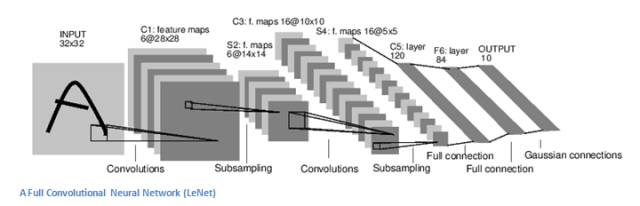

CNN的衍生充分参考了生物里的神经元机制，即生物在感知现实里的特征时，一些神经元对垂直的边缘兴奋，而其他的神经元可能对水平边缘比较兴奋...，当神经元排列好后，一起工作可以进行感知。这个与CNN的思想相似。

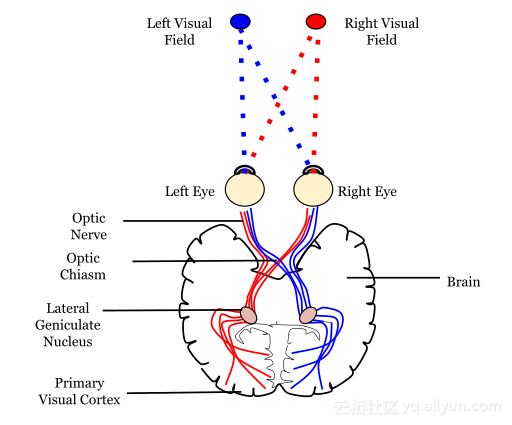

首先从最简单的一张灰度图片开始：

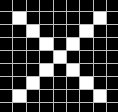

为了让计算机能够识别这张图片，那么人为先预先给图片打一个标签：$$label=X$$

实际上，标签为X的图片并不一定是规整的：

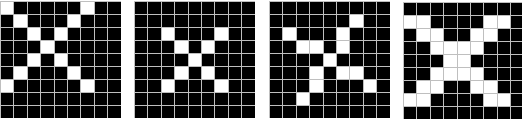

对上面的图片观察发现，虽然细节上存在着不同，但是在整体上存在一些模式（pattern），能不能通过这些pattern去设计神经网络，来实现计算机的图像识别？

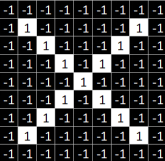

### 全连接层

第一个选择：FCL-fully connected layer

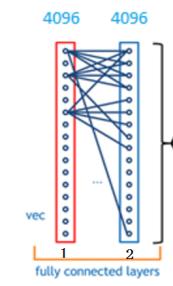

全连接层存在的问题：
* 图像的尺寸相对很大，参数过多难以训练

$$features = 224 \times 224 \times 3 = 150528$$
假设第一层neuron数目为1024，那么仅仅第一层的参数量就是：
$$neurons = 150528 \times 1024 \gt 150 \quad million$$

* 图片特征的位置是可变的

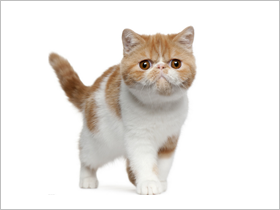

因此我们希望有一种网络，能够克服上述的一些问题。

### Filter

标准的X图片与一张非标准的X图片:


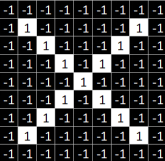

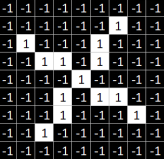

初步的观察，发现：

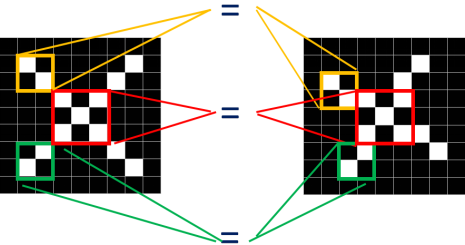

这三个颜色的框在两张图片里均出现了，那么我们可以以这三个特征(feature)来探测图片的某个局部（为了让三个特征的大小一致，统一为3x3），3x3称之为感受野（receptive field)：

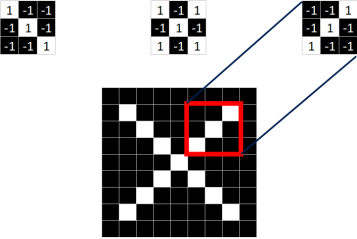

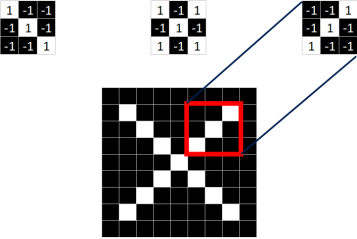

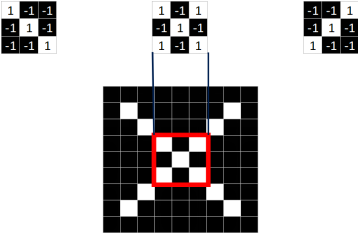

这种人为设计Filter，是传统CV的做法，像Sobel Filter，Gauss Filter等等。

### 卷积运算

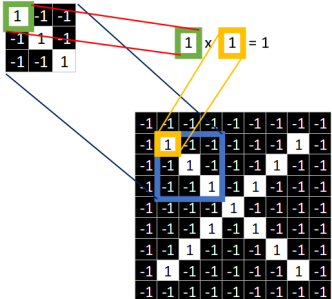

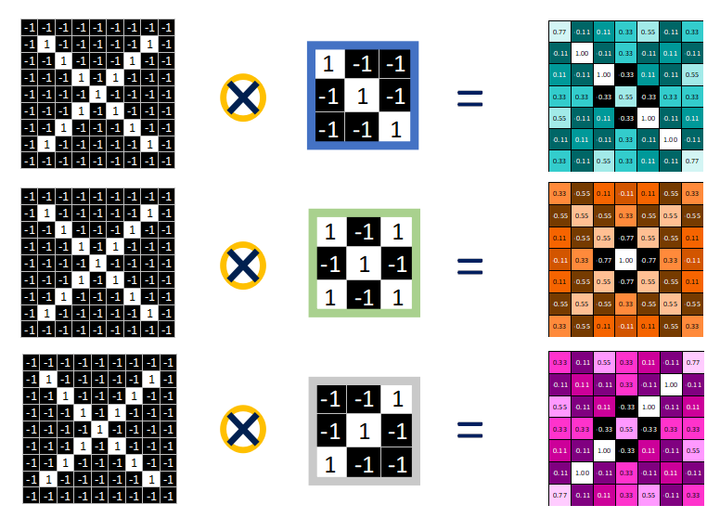

### 非线性激活层

Element-wise Relu，增强神经元的表达能力

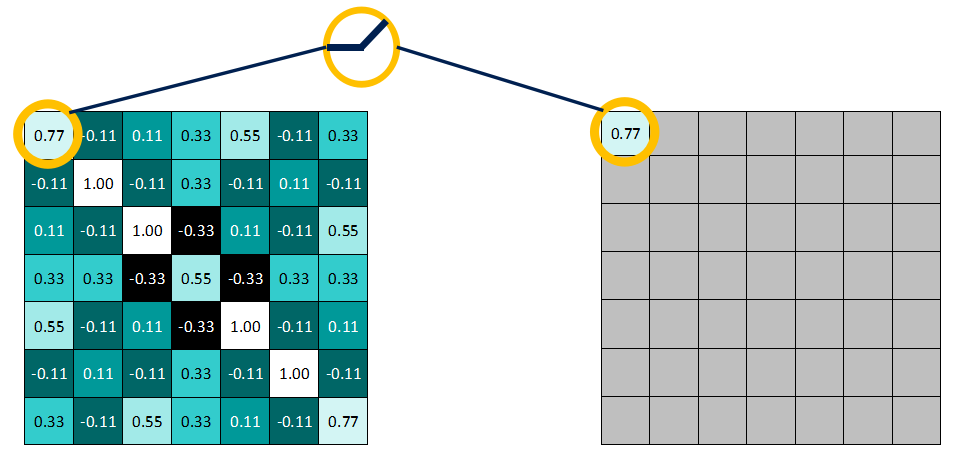

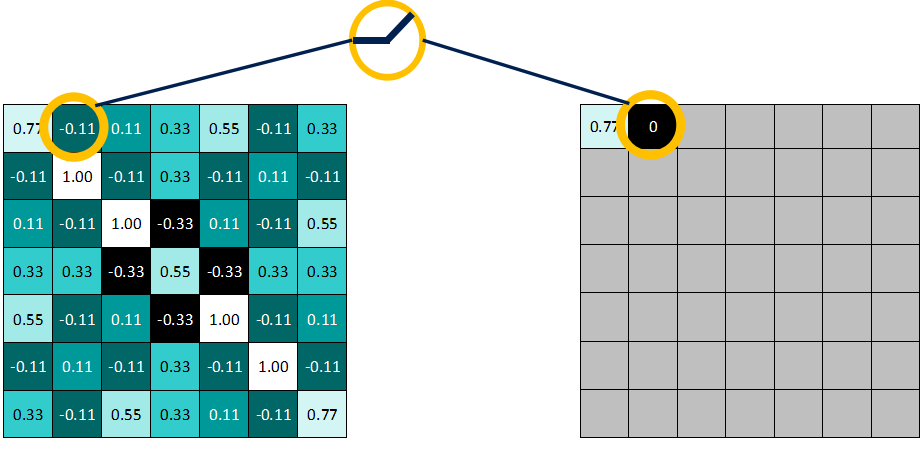

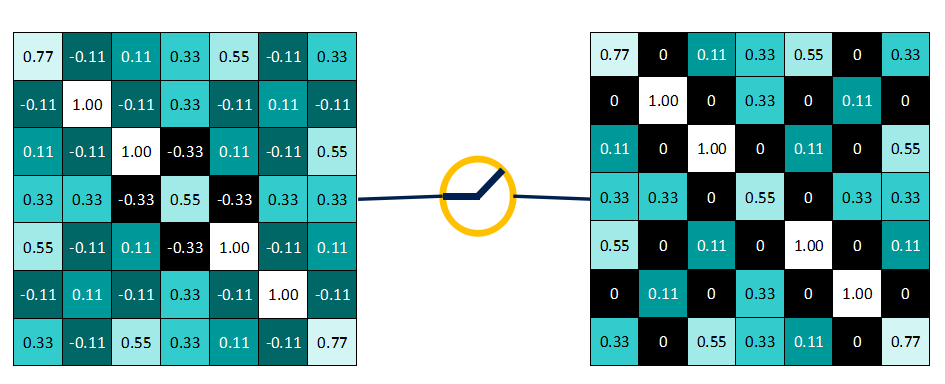

### Padding 补0

在卷积神经网络中，经常需要卷积后的feature map大小与原图像一致，这时候需要进行same padding：

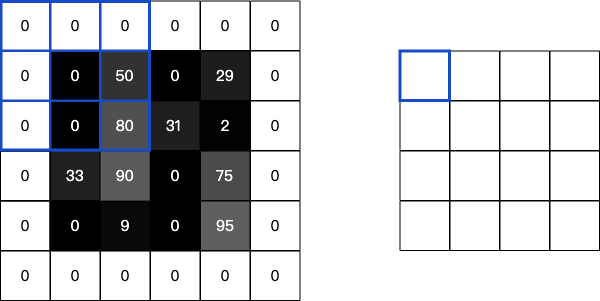

### Pooling 下采样

Pooling的原理来源于在实际图像中，像素周围的值很多是相似的，因此卷积层的输出中相邻的像素值是差不多，这样存在着信息的冗余。pooling层就是对
这些冗余的信息进行缩小：

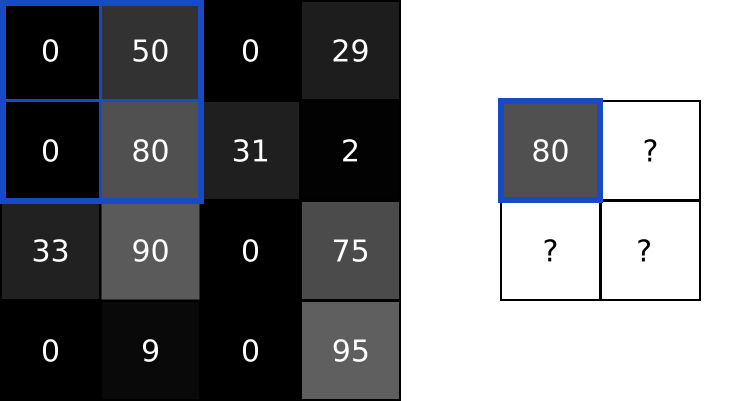

### The whole CNN

CNN的主要网络构成已经介绍完了，常规上，一个CNN网络包含下图中的一些步骤:

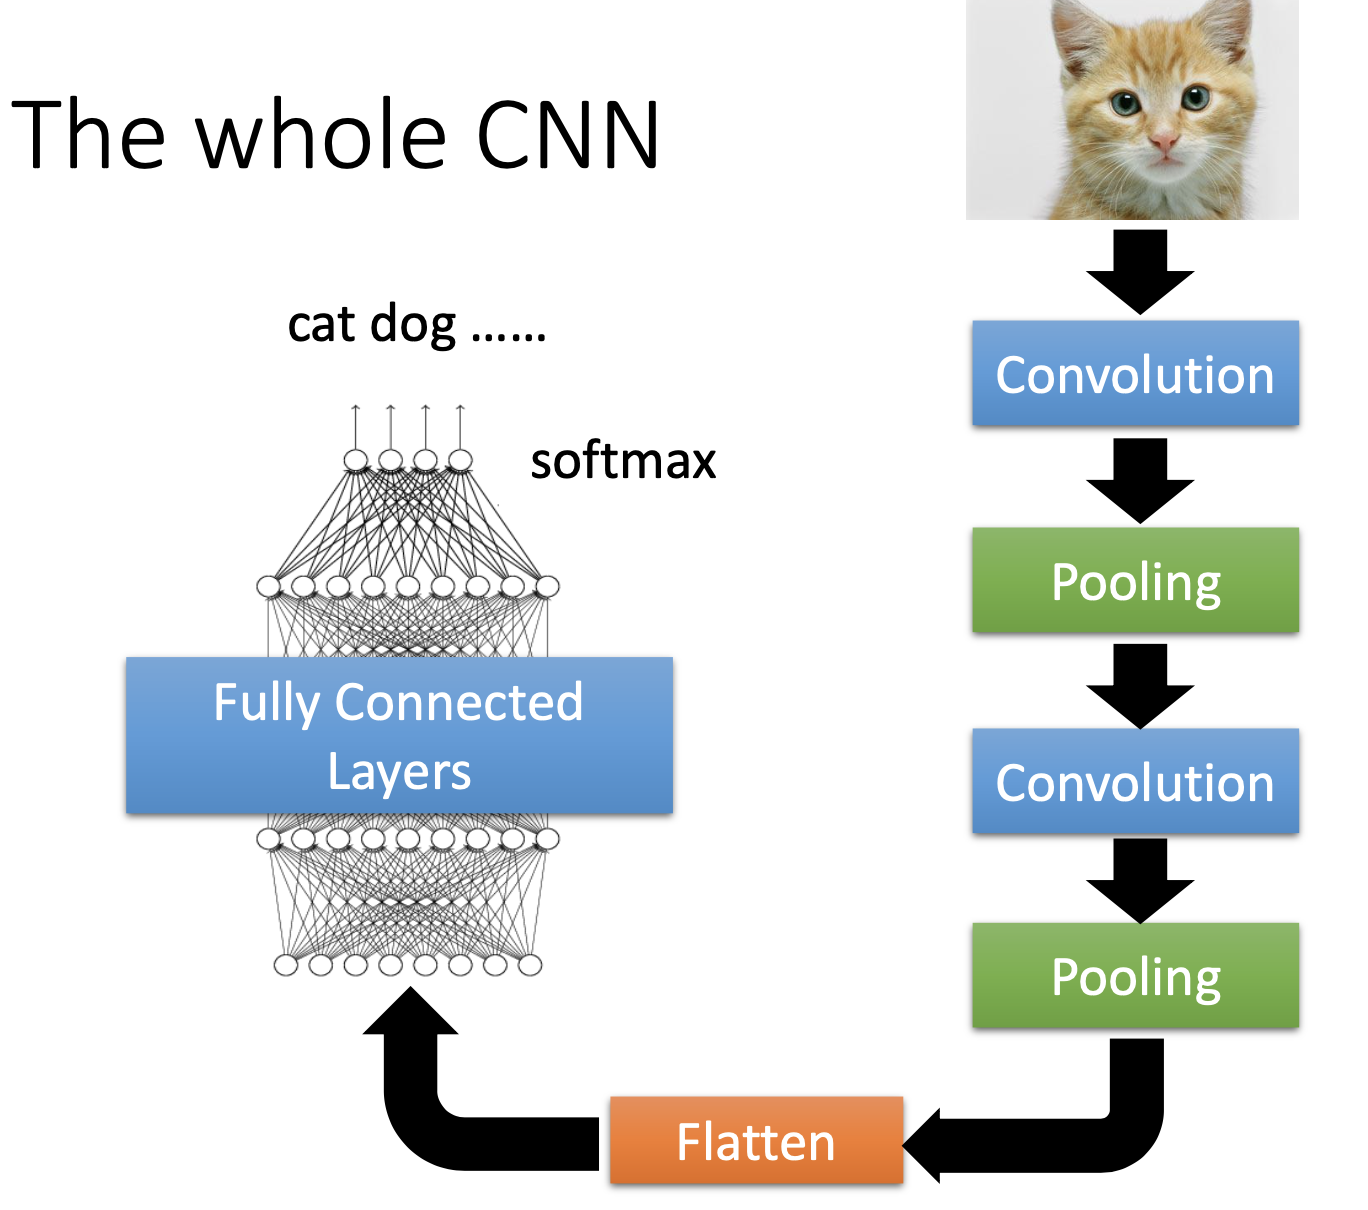

## CNN Demo

训练一个分类器：基于CIFAR10数据集:

```python
label = [‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’]
```

$$image\_size = 3 \times 32 \times 32$$

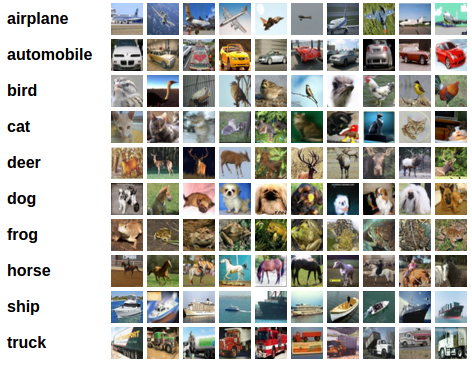

#### 1.Load Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#avoid crash related to ompl -.-
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


加载数据集并将pytorch提供的PILImage格式的[0,1]归一化到[-1,1]

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

In [3]:
batch_size = 4

In [4]:
#训练集
train_set = torchvision.datasets.CIFAR10(root = '/Users/bob/docs/dataset', train=True,
                                        download=True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=2)

Files already downloaded and verified


In [5]:
#测试集
test_set = torchvision.datasets.CIFAR10(root='/Users/bob/docs/dataset', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
#类别标签

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

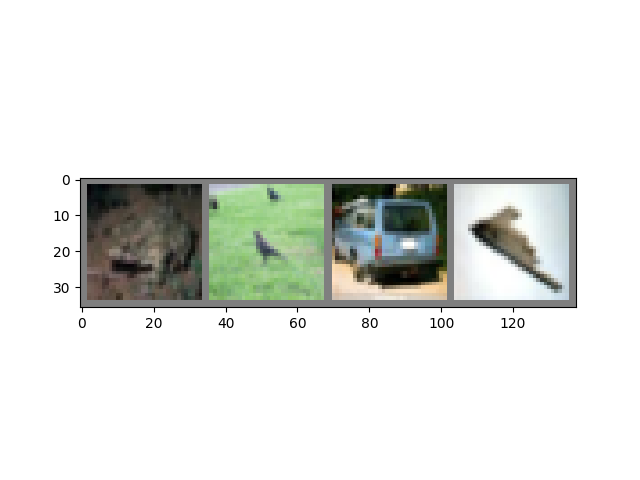

```python

frog  bird   car plane

```

#### 2.定义CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv_2 = nn.Conv2d(6,16,5)
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120,84)
        self.fc_3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        
        return x

In [9]:
model = Net()

#### 3.定义损失函数和优化器

In [10]:
import torch.optim as optimzer

In [11]:
cross_entropy = nn.CrossEntropyLoss()
opt = optimzer.SGD(model.parameters(), lr = 0.001, momentum=0.9)

#### 4.训练

In [12]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        opt.zero_grad()
        
        outputs = model(inputs)
        
        loss = cross_entropy(outputs, labels)
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.190
[1,  4000] loss: 1.844
[1,  6000] loss: 1.665
[1,  8000] loss: 1.585
[1, 10000] loss: 1.514
[1, 12000] loss: 1.472
[2,  2000] loss: 1.376
[2,  4000] loss: 1.371
[2,  6000] loss: 1.348
[2,  8000] loss: 1.318
[2, 10000] loss: 1.291
[2, 12000] loss: 1.264


#### 5.保存模型

In [13]:
dummy_input = torch.randn(4,3,32,32,dtype=torch.float32,device='cpu')

In [14]:
torch.onnx.export(
    model,
    (dummy_input,),
    "cifar10_demo.onnx",
    verbose=False,
    input_names=["image"],
    output_names=["classes"]
)

#### 6.测试网络

In [15]:
data_iter = iter(test_loader)

In [16]:
images,labels = data_iter.next()

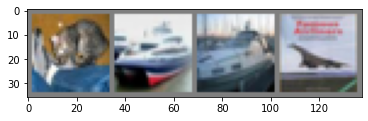

GroundTruth:    cat  ship  ship plane


In [17]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = model(images)

In [19]:
_, predicted = torch.max(outputs,1)

In [21]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [25]:
# Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [27]:
#Accuracy on Every class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 70 %
Accuracy of  bird : 58 %
Accuracy of   cat : 36 %
Accuracy of  deer : 52 %
Accuracy of   dog : 32 %
Accuracy of  frog : 62 %
Accuracy of horse : 54 %
Accuracy of  ship : 67 %
Accuracy of truck : 63 %


### Reference

1. [Pytorch CIFAR10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

2. [Introduction to CNN](https://victorzhou.com/blog/intro-to-cnns-part-1/)

3. [卷积神经网络](https://www.youtube.com/watch?v=OP5HcXJg2Aw&t=57s)

4. [CNN Explainer](https://poloclub.github.io/cnn-explainer/)